In [1]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

from functions.cleaner import clean_numeric_features
from functions.pipeline import balance_with_resample, create_pipeline

# Загрузка данных
df_train = pd.read_csv("train.csv")
del df_train["id"]
print("Shape:", df_train.shape)
print("Columns:", df_train.columns.tolist())
num_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]


unknown_cols = ["job", "education", "default", "poutcome"]
for col in unknown_cols:
    unknown_ratio = (df_train[col] == "unknown").mean()
    print(f"{col}: unknown ratio = {unknown_ratio:.2%}")


imp = SimpleImputer(strategy="most_frequent")
for col in ["job", "education"]:
    df_train[[col]] = imp.fit_transform(df_train[[col]])

Shape: (750000, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
job: unknown ratio = 0.39%
education: unknown ratio = 2.84%
default: unknown ratio = 0.00%
poutcome: unknown ratio = 89.66%


# Построение гистрограмм

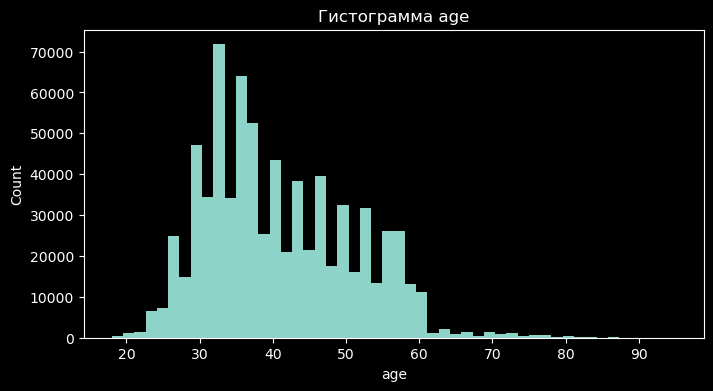

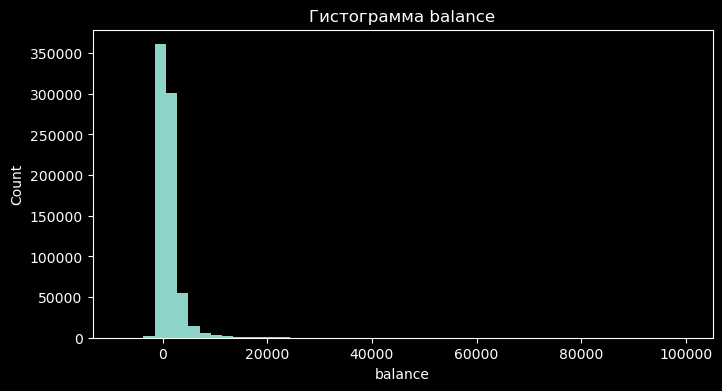

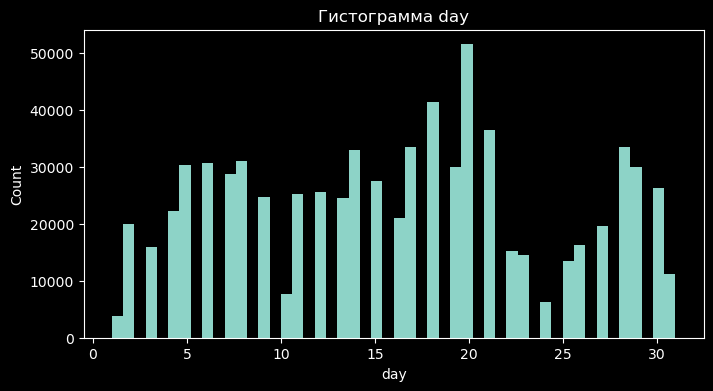

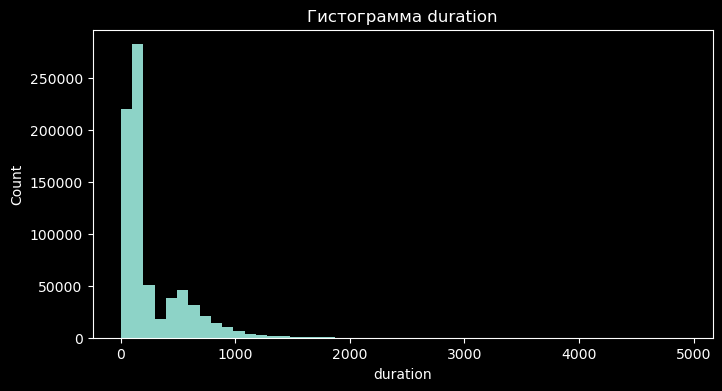

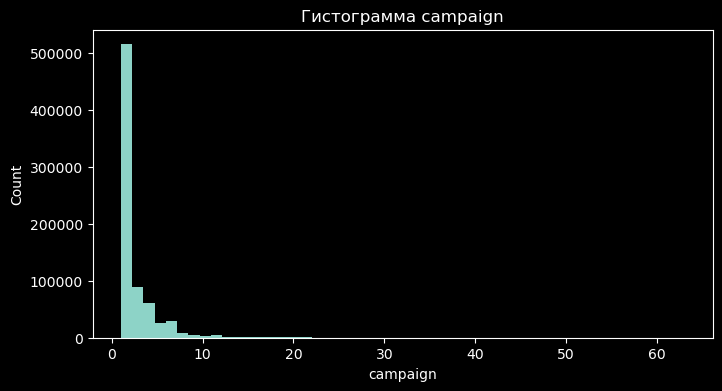

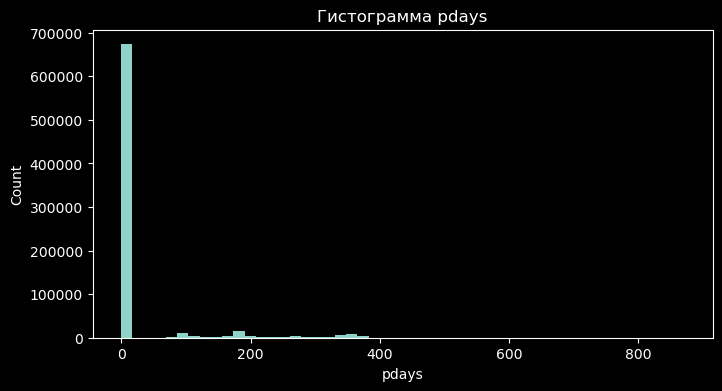

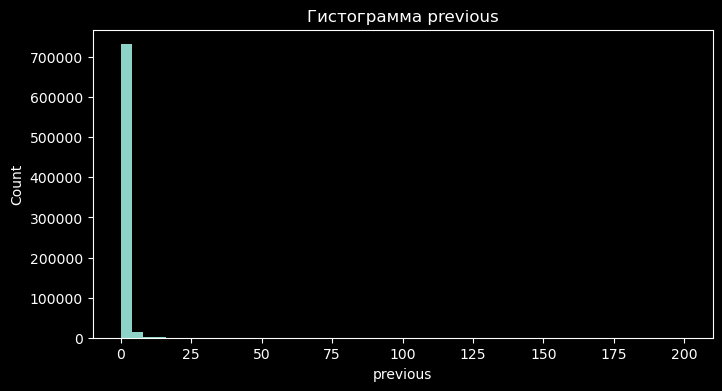

In [2]:
for col in num_features:
    plt.figure(figsize=(8, 4))
    df_train[col].hist(bins=50)
    plt.title(f"Гистограмма {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(False)
    plt.show()

# Очистка

In [3]:
df_train = clean_numeric_features(df=df_train)

bins = [0, 30, 50, 100]
labels = ["young", "adult", "elder"]
df_train["age_group"] = pd.cut(df_train["age"], bins=bins, labels=labels)

iso = IsolationForest(contamination=0.01, random_state=42)
yhat = iso.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


ee = EllipticEnvelope(contamination=0.01, random_state=42)
yhat = ee.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
yhat = lof.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


print(df_train)

Removed 25 rows with age <18 or >90
Removed 14908 rows with extreme balance values
Correlation of duration with target: 0.519
Removed 22207 rows with extreme duration values
Removed 22790 rows with campaign >30
Replaced pdays=-1 with 999
Removed 28708 rows with extreme previous values
Total rows removed: 28708 (3.83%)
Final shape: (721292, 19)
        age          job  marital  education default  balance housing loan  \
0        42   technician  married  secondary      no        7      no   no   
1        38  blue-collar  married  secondary      no      514      no   no   
2        36  blue-collar  married  secondary      no      602     yes   no   
3        27      student   single  secondary      no       34     yes   no   
4        26   technician  married  secondary      no      889     yes   no   
...     ...          ...      ...        ...     ...      ...     ...  ...   
749992   56     services  married  secondary      no     2089     yes   no   
749994   31    housemaid   sin

# Балансировка классов

In [5]:
X_train = df_train.drop(columns=["y"])
y_train = df_train["y"]

print("До балансировки:")
print(y_train.value_counts(normalize=True))


X_bal, y_bal = balance_with_resample(X_train, y_train, method="over")

print("\nПосле балансировки:")
print(y_bal.value_counts(normalize=True))
print(f"Размер X_bal: {len(X_bal)}")

До балансировки:
y
0    0.898085
1    0.101915
Name: proportion, dtype: float64

После балансировки:
y
0    0.5
1    0.5
Name: proportion, dtype: float64
Размер X_bal: 1257082


In [6]:
y_train = (y_bal == 1).astype(int)
X_train = X_bal.copy()


print("Unique values in y_train:", np.unique(y_train))
print("Value counts in y_train:\n", pd.Series(y_train).value_counts(normalize=True))


if "id" in X_train.columns:
    X_train = X_train.drop("id", axis=1)

# 7. Проверяем наличие всех фичей
cat_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]


missing_features = [f for f in num_features + cat_features if f not in X_train.columns]
if missing_features:
    raise ValueError(f"Missing features in X_train: {missing_features}")

Unique values in y_train: [0 1]
Value counts in y_train:
 y
0    0.5
1    0.5
Name: proportion, dtype: float64


## Создание новых признаков

In [7]:
X_bal["has_previous_contact"] = (X_bal["pdays"] != -1).astype(int)

X_bal["is_contacted_recently"] = (X_bal["pdays"] < 30).astype(int)


season_map = {
    "mar": "spring",
    "apr": "spring",
    "may": "spring",
    "jun": "summer",
    "jul": "summer",
    "aug": "summer",
    "sep": "autumn",
    "oct": "autumn",
    "nov": "autumn",
    "dec": "winter",
    "jan": "winter",
    "feb": "winter",
}
X_bal["contact_season"] = X_bal["month"].map(season_map)


X_bal["campaign_binned"] = pd.cut(
    X_bal["campaign"],
    bins=[0, 1, 5, 10, np.inf],
    labels=["none", "low", "medium", "high"],
)


balance_bins = [-np.inf, 0, 500, 2000, np.inf]
balance_labels = ["negative", "low", "medium", "high"]
X_bal["balance_group"] = pd.cut(
    X_bal["balance"], bins=balance_bins, labels=balance_labels
)

# Настройка моделей

In [8]:
models: List[
    Tuple[
        str, Union[LogisticRegression, RandomForestClassifier, CatBoostClassifier], bool
    ]
] = [
    (
        "LogisticRegression",
        LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced"),
        True,
    ),
    (
        "RandomForest",
        RandomForestClassifier(
            n_estimators=50,
            max_depth=12,
            max_features="sqrt",
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        ),
        False,
    ),
    (
        "CatBoost",
        CatBoostClassifier(
            random_state=42,
            iterations=2000,
            early_stopping_rounds=100,
            verbose=0,
            auto_class_weights="Balanced",
        ),
        False,
    ),
]

In [9]:
for model_name, model, use_splines in models:
    print(f"\n=== Оценка модели {model_name} ===")
    pipeline: Pipeline = create_pipeline(model, num_features, cat_features, use_splines)

    split_success: bool = False
    for rs in [42, 123, 456, 777, 0]:
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train,
            y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=rs,
            shuffle=True,
        )
        if len(np.unique(y_train_split)) >= 2 and len(np.unique(y_val)) >= 2:
            print(f"Разделение успешно с random_state={rs}")
            print("Классы в train_split:", np.unique(y_train_split))
            print("Классы в val:", np.unique(y_val))
            split_success = True
            break
        info_break = f"Разделение не удалось с rs={rs}"
        info_train_classes = f"train_classes={np.unique(y_train_split)}, "
        info_val_classes = f"val_classes={np.unique(y_val)}"
        print(f"{info_break}, {info_train_classes} {info_val_classes}")

    if split_success:
        pipeline.fit(X_train_split, y_train_split)
        y_pred: np.ndarray = pipeline.predict(X_val)
        y_pred_proba: np.ndarray = pipeline.predict_proba(X_val)[:, 1]
        print("\nОтчет по классификации:")
        print(classification_report(y_val, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")
    else:
        print("Разделение не удалось — кросс-валидация.")
        cv: StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores: np.ndarray = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1
        )
        print(f"Результаты кросс-валидации AUC-ROC: {cv_scores}")
        print(f"Средний AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    pipeline.fit(X_train, y_train)
    df_test: pd.DataFrame = pd.read_csv("test.csv")
    X_test: pd.DataFrame = df_test.drop("id", axis=1)
    test_predictions: np.ndarray = pipeline.predict_proba(X_test)[:, 1]
    submission: pd.DataFrame = pd.DataFrame(
        {"id": df_test["id"], "y": test_predictions}
    )
    submission.to_csv(f"{model_name}_submission.csv", index=False)
    print(f"Файл с предсказаниями для {model_name} создан!")

print("\nВсе модели обучены и предсказания сохранены!")


=== Оценка модели LogisticRegression ===
Разделение успешно с random_state=42
Классы в train_split: [0 1]
Классы в val: [0 1]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88    125709
           1       0.86      0.91      0.89    125708

    accuracy                           0.88    251417
   macro avg       0.88      0.88      0.88    251417
weighted avg       0.88      0.88      0.88    251417

AUC-ROC: 0.9474
Файл с предсказаниями для LogisticRegression создан!

=== Оценка модели RandomForest ===
Разделение успешно с random_state=42
Классы в train_split: [0 1]
Классы в val: [0 1]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89    125709
           1       0.86      0.95      0.90    125708

    accuracy                           0.90    251417
   macro avg       0.90      0.90      0.90    251417
weighted avg       0.90      0.90 